In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
!pip install openpyxl

## Analysis of the theoretical model
### Varying the baseline probability of seeing a type of story $p_i$
We begin by first examining how the apparent treatment effect, varies according to the baseline rate at which stories are observed. 

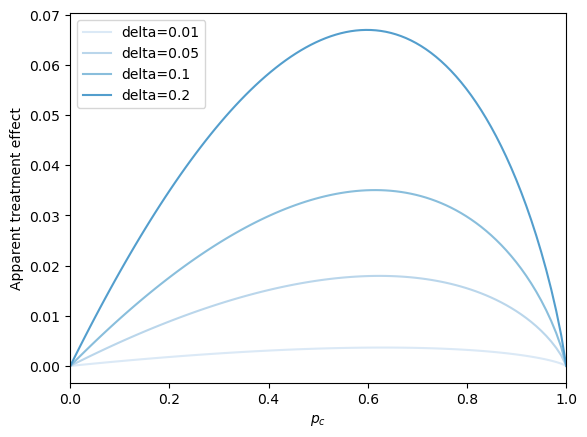

In [ ]:
x = np.linspace(0, 1, 100)

pal = sns.color_palette("Blues", 6)
for idx, delta in enumerate([0.01, 0.05, 0.1, 0.2]):
    y = 1 - (1-x)**(1+delta) - x
    plt.plot(x, y, label=f'delta={delta}', color=pal[idx])

plt.xlabel(r'$p_c$')
plt.ylabel(r'$p_t - p_c$')
plt.legend()
plt.xlim(0, 1)
plt.savefig('./out/apparent_treatment_effect_with_delta.png', dpi=300)

Notice in the figure above that intermediately-common news items ($p_i\approx0.6$) will exhibit much larger apparent effects than rarer classes of news items ($p_i\approx.2$). Intuitively, this is a consequence of the fact that rarer news, even under similarly increased exposure, will be less likely to show up in the finite collection of items. For very frequent items, the the effect size is reduced by ceiling effects; news items that everyone will see anyway can only be increased so much. 

### Varying Number of Stories (N)
However, the author's analysis adds an additional wrinkle: News stories across classes (False, True, Placebo) vary not just in the frequency of reported exposure but likewise in the number of stories. While this does not change the expectation $p_i$, the authors relied not on a binomial model but on a linear model. As a result, their observable was the number of stories viewed adding a multiplicative effect. Considering just this factor and keeping $\delta constant we observe the following: 

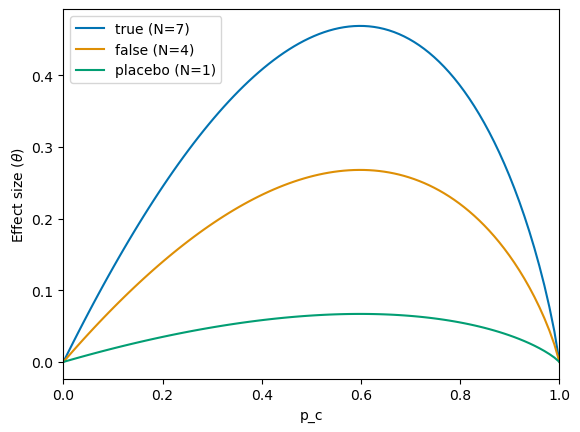

In [21]:
x = np.linspace(0, 1, 100)

pal = sns.color_palette("colorblind", 3)
labels = ['placebo (N=1)', 'false (N=4)', 'true (N=7)']
for idx, N in enumerate([1, 4, 7][::-1]):
    y = 1 - (1-x)**(1+delta) - x
    plt.plot(x, y*N, label=labels[::-1][idx], color=pal[idx])

plt.xlabel('p_c')
plt.ylabel(r'Effect size ($\theta$)')
plt.legend()
plt.xlim(0, 1)
plt.savefig('./out/Variation_by_N.png', dpi=300)


### Bias in effect size estimate

Both of the effects combine, such that True items should exhibit larger effect sizes from both their increased frequency of exposure *and* the increased number of items. We can put these together to examine the expected effect sizes under *identical* delta for the frequency with which placebo, true, and false items were reported as exposed by the participants. Here we show the expected effect sizes given the observed change in proportion of identfied Wave 2 true stories

Placebo p_i: 0.13153153153153152, n_i: 1
False p_i: 0.2906906906906907, n_i: 4
True p_i: 0.46906906906906903, n_i: 7
Placebo: 0.003802633085258744
False: 0.03016112632501078
True: 0.07250089444087077


/var/folders/72/_pfms6fx20bglywcmxhtkgh00000gn/T/ipykernel_71593/4105828744.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='label', y='y_i', palette=pal[::-1])


0.031116437484159265

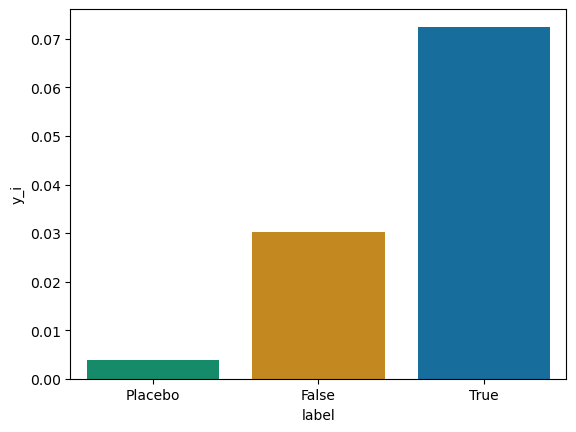

In [22]:

##Calculate observed delta_p
Data_FA= pd.read_csv('./data/LongFalseAwareFR.csv')

Wave2 = Data_FA[Data_FA['Wave'] == 2]

Cobs = Wave2.groupby('Control_Treatment')['Total_TRUE_AWARE_W2'].mean().iloc[0]
Tobs = Wave2.groupby('Control_Treatment')['Total_TRUE_AWARE_W2'].mean().iloc[1]
obs_delta_p = Tobs/7 - Cobs/7
p_i = Cobs/7
obs_delta = (np.log(1-p_i) - obs_delta_p)/np.log(1-p_i) - 1


Data_FA= pd.read_csv('./data/LongFalseAwareFR.csv')
Control = Data_FA[Data_FA['Control_Treatment'] == 'Control']
#Wave2
Control = Control[Control['Wave'] == 2]


n_i_placebo = Control['PLACEBO_awareness'].max()
n_i_false = Control['false_aware'].max()
n_i_true = Control['Total_TRUE_AWARE_W2'].max()

p_i_placebo = Control['PLACEBO_awareness'].mean() / n_i_placebo
p_i_false = Control['false_aware'].mean() / n_i_false
p_i_true = Control['Total_TRUE_AWARE_W2'].mean() / n_i_true

print(f'Placebo p_i: {p_i_placebo}, n_i: {n_i_placebo}')
print(f'False p_i: {p_i_false}, n_i: {n_i_false}')
print(f'True p_i: {p_i_true}, n_i: {n_i_true}')

def observed(p_i, n_i, delta=.1):
    y_i = 1 - (1-p_i)**(1+obs_delta) - p_i
    return y_i * n_i

print(f'Placebo: {observed(p_i_placebo, n_i_placebo)}')
print(f'False: {observed(p_i_false, n_i_false)}')
print(f'True: {observed(p_i_true, n_i_true)}')

#plot
plot_df = pd.DataFrame({
    'y_i': [observed(p_i_placebo, n_i_placebo), observed(p_i_false, n_i_false), observed(p_i_true, n_i_true)],
    'label': ['Placebo', 'False', 'True']
})
sns.barplot(data=plot_df, x='label', y='y_i', palette=pal[::-1])
obs_delta


### Bias in estimation of the variance 
The above demonstrates that even for identical effect sizes, the design of the experiment will lead to exaggerated effect sizes in the true condition relative to the false condition and the Placebo. However, the authors choice of model results in yet another wrinkle as the variance would likewise be expected to change across conditions. Recall that the variance of a binomial distribution is: 


\begin{align}
\sigma^2 = N * p * (1-p)
\end{align}

Plugging in values, the expected variance under each condition, for $\delta=.1$ is as shown below. 

/var/folders/72/_pfms6fx20bglywcmxhtkgh00000gn/T/ipykernel_71593/269888184.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=var_plotting_df, x='label', y='variance', palette=pal[::-1])


<Axes: xlabel='label', ylabel='variance'>

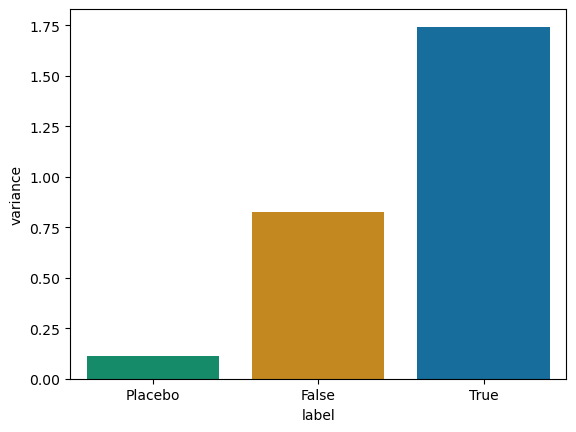

In [23]:
var_placebo = n_i_placebo * p_i_placebo * (1 - p_i_placebo)
var_false = n_i_false * p_i_false * (1 - p_i_false)
var_true = n_i_true * p_i_true * (1 - p_i_true)

var_plotting_df = pd.DataFrame({
    'variance': [var_placebo, var_false, var_true],
    'label': ['Placebo', 'False', 'True']
})
sns.barplot(data=var_plotting_df, x='label', y='variance', palette=pal[::-1])

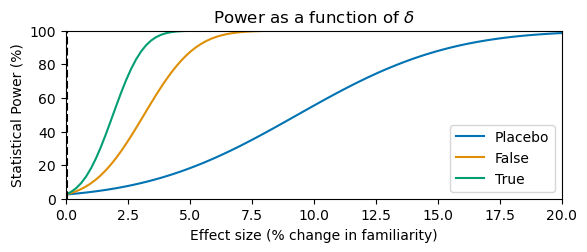

In [25]:
from scipy import stats
N = Data_FA[Data_FA['Wave'] == 2].shape[0]

def get_power(p_i, N, n, delta=np.linspace(0, .2, 100)):
    y_i = 1 - (1-p_i)**(1+delta) - p_i
    theta = y_i * N
    SE = np.sqrt((N * p_i * (1 - p_i))/n + (N * (p_i + y_i) * (1 - p_i - y_i))/n)
    sigma = np.sqrt((N * p_i * (1 - p_i))/n)
    z_crit = stats.norm.ppf(0.975)  # two-tailed test, alpha = 0.05
    power = 1 - stats.norm.cdf(z_crit - theta / sigma)
    return power*100
delta = np.linspace(0, .2, 100)

plt.subplot(2,1,1)
plt.plot(delta*100, get_power(p_i_placebo, N, n_i_placebo, delta), label='Placebo', color=pal[0])
plt.plot(delta*100, get_power(p_i_false, N, n_i_false, delta), label='False', color=pal[1])
plt.plot(delta*100, get_power(p_i_true, N, n_i_true, delta), label='True', color=pal[2])
plt.xlabel(r'$\delta$')
plt.ylabel('Statistical Power (%)')
plt.xlabel('Effect size (% change in familiarity)')
plt.title('Power as a function of $\delta$')
plt.legend()
plt.xlim(0,20)
plt.ylim(0, 100)

plt.plot([obs_delta, obs_delta], [0, 100], 'k--', label='Observed Effect Size')
plt.savefig('./out/Power_Curves.png', dpi=300)


### Theory: Conclusion
In the above, note that the dashed line corresponds to the observed change in Wave 2, corresponding to approximately a 3% change in exposure from treatment. At this observed level, and under a normal approximation (as in the author's linear model), the power to detect increases in True exposure is considerably higher than the power to detect increases in False Exposure.

This general trend should apply equally, or perhaps even more so to questions about belief as presumably belief is largely downstream of exposure. Moreover, discernment is calculated as a simple difference between belief such that the same issues are in effect there. In effect, the smaller artifactual effect size for False items is subtracted from the larger artifactual effect size for false items. Even if there were truly no changes in belief in false news or discernment, the results of the paper could arise from sheer statistical artifacts. 

However, this does not provide any answers as to what the effect sizes of interest (in terms of $\delta$) actually are. In the following section we'll develop a minimal Bayesian model based on the generative process outlined above to evaluate whether in the simplest case (exposure) the results nonetheless hold. 

# Empirics

Our goal is to estimate $\delta$ given the available data. In contrast to the published work, we can greatly simplify the causal identification leveraging the fact that it was a randomized controlled trial. Specifically, we need not include (and shouldn't) the placebo as a predictor, as it is a post-treatment variable measured in Wave 2. Likewise, we need not include the Wave 1 data as outcomes given that they occurred prior to treatment. Moreover, rather than leveraging a linear model (which leads to the issues above) we will use a binomial distribution that enables us to avoid such pitfalls. Specifically, we'll assume: 


\begin{align}
a_\mu &\sim \mathcal{N}(0,1) \\
\alpha_j &\sim \mathcal{N}(a_\mu,1) \quad j \in \{0,1,2\} \\
b_\mu &\sim \mathcal{N}(0,1) \\
\beta_j &\sim \mathcal{N}(b_\mu,1) \quad j \in \{0,1,2\} \\

\mu_{T,A} &= \alpha_0 + \beta_0 A \\
\mu_{F,A} &= \alpha_1 + \beta_1 A \\
\mu_{P,A} &= \alpha_2 + \beta_2 A \\

p_{T,A} &= \text{invLogit}(\mu_{T,A}) \\
p_{F,A} &= \text{invLogit}(\mu_{F,A}) \\
p_{P,A} &= \text{invLogit}(\mu_{P,A}) \\

y_T &\sim \text{Binomial}(7, p_{T,A}) \\
y_F &\sim \text{Binomial}(4, p_{F,A}) \\
y_P &\sim \text{Binomial}(1, p_{P,A})
\end{align}

Here, y indicates the number of items identified by participants as familiar. We assume it's distributed binomially according to the probability of reporting an item as having been observed which depends on an intercept ($\alpha$) and effect of treatment ($\beta$). Effectively this is a very simple binomial model, albeit jointly modeled for some partial pooling across parameters. 

Given the theory above, we can additionally calculate the $\delta$ change in exposure based on the the change in $p$ from treatment to control. Consider the case of True information, the change in expected probability of famliarity with an item is: 

\begin{align}
\Delta p_T &= \text{invLogit}(\alpha_0 + \beta_0) - \text{invLogit}(\alpha_0)
\end{align}

And the probability in the control case is: 
\begin{align}
p_T &= \text{invLogit}(\alpha_0)
\end{align}

To recover $\delta$, we can lean on the relationship above: 

\begin{align}
\Delta p_T &= 1 - (1 - p_T)^{1 + \delta} - p_T
\end{align}

Solving for $\delta$ yields:

\begin{align}
\delta &= \frac{\log((1 - p_T) - \Delta p_T)}{\log(1 - p_T)} - 1
\end{align}

In our model, we can calculate posterior estimates of the change in exposure, $\delta$ for each of the items using the above formula. 


In [26]:
wave2 = Data_FA[Data_FA['Wave'] == 2]
with pm.Model() as awarenessModel:
    #Data
    K_p = pm.Data('K_p', 1)
    y_P_obs = pm.Data('y_P_obs', wave2['PLACEBO_awareness'].values)
    y_T_obs = pm.Data('y_T_obs', wave2['Total_TRUE_AWARE_W2'].values)
    y_F_obs = pm.Data('y_F_obs', wave2['false_aware'].values)
    A = pm.Data('A', wave2['Control_Treatment'].values =='Treatment')
    n = pm.Data('n', wave2.shape[0])
    
    #Priors

    
    a_mu = pm.Normal("a_mu", mu=0, sigma=1)  # Mean of the intercepts
    alpha = pm.Normal("alpha", mu=a_mu, sigma=1, shape=3)  # Intercept for each group
    
    b_mu = pm.Normal("b_mu", mu=0, sigma=1)  # Mean of the slopes
    beta = pm.Normal("beta", mu=b_mu, sigma=1, shape=3)  # Slope for each group
   

    #Liklihood for Placebo
    mu_F = alpha[1] + beta[1] * A
    mu_T = alpha[0] + beta[0] * A
    mu_PA = alpha[2] + beta[2] * A
    
    p_F = pm.Deterministic("p_F", pm.math.invlogit(mu_F))
    p_T = pm.Deterministic("p_T", pm.math.invlogit(mu_T))
    p_PA = pm.Deterministic("p_PA", pm.math.invlogit(mu_PA))
    
    # Observed
    y_F = pm.Binomial("y_F", n=4, p=p_F, observed=y_F_obs)
    y_T = pm.Binomial("y_T", n=7, p=p_T, observed=y_T_obs)  
    y_P = pm.Binomial("y_P",n=1, p=p_PA, observed=y_P_obs)


    # Estimated 
    p_F_control = pm.Deterministic("p_F_control", pm.math.invlogit(alpha[1]))
    p_F_treatment = pm.Deterministic("p_F_treatment", pm.math.invlogit(alpha[1] + beta[1] ))
    p_T_control = pm.Deterministic("p_T_control", pm.math.invlogit(alpha[0]))
    p_T_treatment = pm.Deterministic("p_T_treatment", pm.math.invlogit( alpha[0] + beta[0]))
    p_PA_control = pm.Deterministic("p_PA_control", pm.math.invlogit(alpha[2]))
    p_PA_treatment = pm.Deterministic("p_PA_treatment", pm.math.invlogit(alpha[2] + beta[2]))
    
    #delta_p
    delta_p_F = pm.Deterministic("delta_p_F", p_F_treatment - p_F_control)
    delta_p_T = pm.Deterministic("delta_p_T", p_T_treatment - p_T_control)
    delta_p_PA = pm.Deterministic("delta_p_PA", p_PA_treatment - p_PA_control)
    
    #delta
    delta_F = pm.Deterministic("delta_F", pm.math.log((1 - p_F_control - delta_p_F)) / pm.math.log(1 - p_F_control) - 1)
    delta_T = pm.Deterministic("delta_T", pm.math.log((1 - p_T_control - delta_p_T)) / pm.math.log(1 - p_T_control) - 1)
    delta_PA = pm.Deterministic("delta_PA", pm.math.log((1 - p_PA_control - delta_p_PA)) / pm.math.log(1 - p_PA_control) - 1)
    
with awarenessModel:
    fit = pm.sample(draws=1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, alpha, b_mu, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [35]:
az.bfmi(fit)

array([1.12999651, 1.12657584, 1.14921226, 1.04287633])

In [38]:
param_table = az.summary(fit, round_to=2, var_names=['alpha',  'alpha', 'beta', 'delta_F', 'delta_T', 'delta_PA'])
param_table.to_latex('./out/parameter_table.tex', float_format="%.2f")


/var/folders/72/_pfms6fx20bglywcmxhtkgh00000gn/T/ipykernel_71593/3415448402.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=delta_df, x='condition', y='value', palette=pal[::-1], inner='quartile')


(-100.0, 100.0)

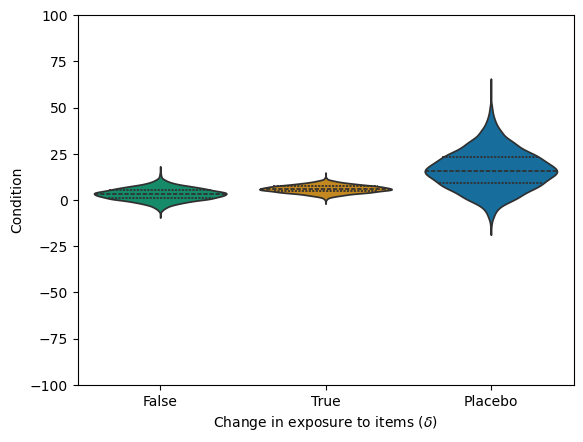

In [ ]:
import pandas as pd 
delta_df = pd.DataFrame({
    'value': np.concatenate([fit.posterior['delta_F'].values.flatten(),
                            fit.posterior['delta_T'].values.flatten(),
                            fit.posterior['delta_PA'].values.flatten()]),
  
    'condition': np.concatenate([np.repeat('False', fit.posterior['delta_F'].values.size),
                                    np.repeat('True', fit.posterior['delta_T'].values.size),
                                    np.repeat('Placebo', fit.posterior['delta_PA'].values.size)])
})

delta_df['value'] = 100 * delta_df['value']
#array for plotting 1, 2, 3 for False, True, Placebo
sns.violinplot(data=delta_df, x='condition', y='value', palette=pal[::-1], inner='quartile')
plt.xlabel("Percent change in exposure to item categories")
plt.ylabel("Condition")
plt.ylim(-100,100)

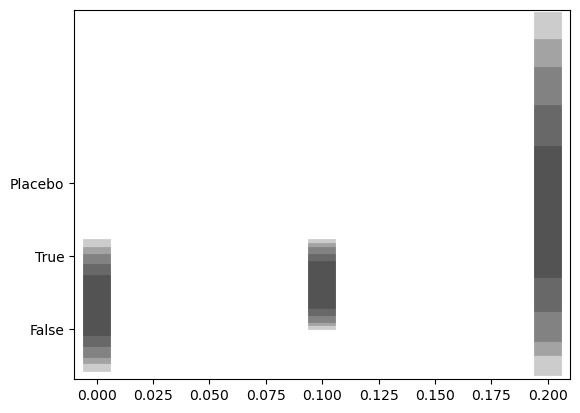

In [59]:
for idx, label in enumerate(['False', 'True', 'Placebo']):
    for ci in [97, 94, 89, 75, 50]:
        hpd = np.percentile(delta_df[delta_df['condition'] == label]['value'], [(100 - ci) / 2, 100 - (100 - ci) / 2])
        plt.plot( [idx/10, idx/10], hpd, color='k', linewidth=20, alpha=.2)

#move y positions together
    plt.yticks([0, .1, .2], ['False', 'True', 'Placebo'])

In [37]:
#Contrast summary table relative to placebo

True_vs_placebo = fit.posterior['delta_T'] - fit.posterior['delta_PA']
False_vs_placebo = fit.posterior['delta_F'] - fit.posterior['delta_PA']
True_V_false = fit.posterior['delta_T'] - fit.posterior['delta_F']

contrast_df = pd.DataFrame({
    'value': np.concatenate([True_vs_placebo.values.flatten(),
                             False_vs_placebo.values.flatten(),
                             True_V_false.values.flatten()]),
    'condition': np.concatenate([np.repeat('True vs Placebo', True_vs_placebo.values.size),
                                 np.repeat('False vs Placebo', False_vs_placebo.values.size),
                                 np.repeat('True vs False', True_V_false.values.size)])})
out_df = pd.DataFrame({
    'mean': contrast_df.groupby('condition')['value'].mean(),
    'sd': contrast_df.groupby('condition')['value'].std(),
    'hpd_3': contrast_df.groupby('condition')['value'].quantile(0.03),
    'hpd_97': contrast_df.groupby('condition')['value'].quantile(0.97)
}).round(2).reset_index().rename(columns={'value': 'contrast'})

#round to 2 decimal places
out_df.to_latex('./out/contrast_table.tex', float_format="%.2f")
out_df

,condition,mean,sd,hpd_3,hpd_97
0,False vs Placebo,-0.13,0.11,-0.35,0.07
1,True vs False,0.03,0.04,-0.04,0.10
2,True vs Placebo,-0.10,0.11,-0.32,0.09


In [44]:
True_vs_placebo = fit.posterior['delta_T'] - fit.posterior['delta_PA']
False_vs_placebo = fit.posterior['delta_F'] - fit.posterior['delta_PA']
True_V_false = fit.posterior['delta_T'] - fit.posterior['delta_F']

print(1-np.mean((True_vs_placebo > 0)))
print(1-np.mean((False_vs_placebo > 0)))
print(1-np.mean((True_V_false > 0)))

<xarray.DataArray ()>
array(0.82275)
<xarray.DataArray ()>
array(0.8835)
<xarray.DataArray ()>
array(0.237)
